# SET Data Analysis

This notebook contains comprehensive analysis of DSC SET (Student Evaluation of Teaching) data, including data cleaning, exploratory data analysis, and statistical modeling.

In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical and machine learning libraries
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr, spearmanr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, mean_squared_error, r2_score
)
from sklearn.inspection import permutation_importance

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Step 1: Data Cleaning and Feature Engineering

We need to:
1. Extract course numbers from course titles
2. Standardize term formats
3. Clean and extract numeric values from grade fields
4. Merge our data with utilization rate

*Load and clean SETs Data*

In [3]:
# load sets into dataframe
dsc_sets = pd.read_csv('datasets/dsc_sets.csv')

# merge duplicate columns
dsc_sets["Enrolled Resp Rate"] = dsc_sets["Enrolled/ Resp Rate"].fillna(dsc_sets["Enrolled/  Resp Rate"])
dsc_sets = dsc_sets.drop(columns=["Enrolled/ Resp Rate", "Enrolled/  Resp Rate"])

# rename columns for easier access
dsc_sets.columns = dsc_sets.columns.str.replace('*', '', regex=False)
dsc_sets.columns = dsc_sets.columns.str.replace(' ', '_')
dsc_sets['Term'] = dsc_sets['Term'].str.lower()


# Extract the number before the parentheses
dsc_sets['Enrolled_Resp_Number'] = dsc_sets['Enrolled_Resp_Rate'].str.extract(r'(\d+)\s*\(')[0].astype(int)
# Extract the percentage inside parentheses
dsc_sets['Enrolled_Resp_Pct'] = dsc_sets['Enrolled_Resp_Rate'].str.extract(r'\(([\d\.]+)%\)')[0].astype(float)

# remove Letter from Avg Grade Received
dsc_sets["Avg_Grade_Received"] = (
    dsc_sets["Avg_Grade_Received"]
    .str.extract(r'(\d+\.\d+|\d+)')   # extract first number
    .astype(float)
)

# delete unnecessary columns
dsc_sets = dsc_sets.drop(columns=["Course", "Enrolled_Resp_Rate"])
# remove dsc96 course (doesn't have grades)
dsc_sets = dsc_sets[dsc_sets['course_title'] != 'dsc95']

dsc_sets = dsc_sets.dropna(subset=['Avg_Grade_Received'])
dsc_sets.head()

,Instructor,Term,Avg_Grade_Received,Avg_Hours_Worked,Learning_Average,Structure_Average,Environment_Average,course_title,Enrolled_Resp_Number,Enrolled_Resp_Pct
0,"Bellur, Umesh",wi25,3.93,9.93,3.74,3.55,4.12,dsc180b,114,14.04
1,"Bellur, Umesh",wi25,3.99,11.89,4.02,3.74,3.80,dsc180b,118,16.95
2,"Rampure, Suraj",wi24,3.96,9.60,4.60,4.59,4.58,dsc180b,97,10.31
3,"Rampure, Suraj",wi24,3.99,6.23,4.57,4.57,4.53,dsc180b,138,9.42
4,"Weng, Tsui-Wei (lily)",sp25,3.71,7.38,4.19,4.13,4.24,dsc140b,124,45.16


*Merge SETs data with Utilization Rate from WebReg Data*

In [4]:
webreg_data = pd.read_csv('webreg_data/results/webreg_processed_data.csv')
webreg_data.head()
merged_data = webreg_data[['course', 'quarter', 'utilization_rate']]
merged_data = merged_data.copy()

#drop underscore from course column to match dsc_sets
merged_data['course'] = merged_data['course'].str.replace('_', '').str.lower()
merged_data = merged_data.rename(columns={'course': 'course_title', 'quarter': 'Term'})
# merge datasets on course title and term
final_data = pd.merge(dsc_sets, merged_data, on=['course_title', 'Term'], how='inner')
cols = ['course_title'] + [c for c in final_data.columns if c != 'course_title']
final_data = final_data[cols]

final_data.head()

,course_title,Instructor,Term,Avg_Grade_Received,Avg_Hours_Worked,Learning_Average,Structure_Average,Environment_Average,Enrolled_Resp_Number,Enrolled_Resp_Pct,utilization_rate
0,dsc180b,"Bellur, Umesh",wi25,3.93,9.93,3.74,3.55,4.12,114,14.04,98.30
1,dsc180b,"Bellur, Umesh",wi25,3.99,11.89,4.02,3.74,3.80,118,16.95,98.30
2,dsc140b,"Weng, Tsui-Wei (lily)",sp25,3.71,7.38,4.19,4.13,4.24,124,45.16,97.62
3,dsc140b,"Huang, Biwei",wi25,3.53,6.38,4.25,4.27,4.57,42,30.95,29.66
4,dsc100,"Salimi, Babak",sp25,3.63,5.44,4.04,3.61,4.05,139,74.10,92.47


In [5]:
numeric_cols = ['Avg_Grade_Received', 'Avg_Hours_Worked',
                'Learning_Average', 'Structure_Average', 
                'Environment_Average',
                'Enrolled_Resp_Pct']
numeric_df = final_data[numeric_cols].copy()

## Step 2: EDA of SETs + Utilization Data

We set to explore our data with these hypotheses in mind.  
* **Initial Null Hypothesis**: None of the numeric course metrics are linearly related to seat utilization.  
* **Alternative Hypothesis**: At least one numeric predictor has a non-zero linear effect on seat utilization.


### Graph 1: Correlation of Numeric Course Metrics
This visualization shows the pairwise linear correlations among key numeric course metrics in the dataset, focusing on the lower triangle of the correlation matrix to avoid redundancy.

The variables included are:
* Avg_Grade_Received – average grade students earned in the course
* Avg_Hours_Worked – average weekly hours students reported spending on the course
* Learning_Average – students’ evaluation of how much they learned
* Structure_Average – students’ evaluation of the course’s organization and clarity
* Environment_Average – students’ evaluation of the classroom and learning environment
* Enrolled_Resp_Pct – enrollment/response percentage

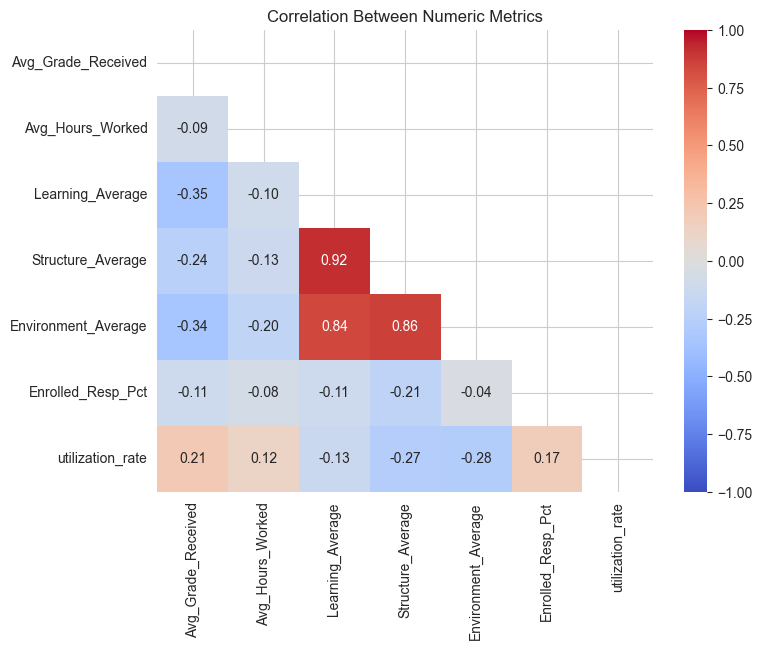

In [6]:
numeric_cols2 = ['Avg_Grade_Received', 'Avg_Hours_Worked',
                'Learning_Average', 'Structure_Average', 
                'Environment_Average',
                'Enrolled_Resp_Pct', 'utilization_rate']

corr = final_data[numeric_cols2].corr()
plt.figure(figsize=(8,6))  # set figure size
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    annot=True,       # show correlation values
    fmt=".2f",        # format numbers
    cmap='coolwarm',  # color map
    vmin=-1, vmax=1,   # fix color scale
    mask=mask      # hide diagonal
)
plt.title("Correlation Between Numeric Metrics")
plt.show()

`Structure_Average`, `Learning_Average`, and `Environment_Average` exhibit strong positive correlations, indicating consistent student perceptions across these aspects, this also is a potential indicator of multi-colinearity. `utilization_rate` on the other hand doesn't have a very strong correlation with any variable, meaning that attempts to find linear correlations with the variables that we have may be weak.

### Test 1: Test for Multi-Colinearity

**Purpose**: Determine if numeric predictors are highly correlated with each other, which can inflate regression coefficients and make them unstable.

**Testing**: 
* **Variance Inflation Factor**: Quantitative measure of multicollinearity.
    * **VIF > 5**: Moderate multicollinearity
    * **VIF > 10**: High multicollinearity



In [7]:
X = numeric_df.dropna() 
X = sm.add_constant(X) 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,899.199039
1,Avg_Grade_Received,1.289189
2,Avg_Hours_Worked,1.092279
3,Learning_Average,7.520313
4,Structure_Average,9.491311
5,Environment_Average,4.794431
6,Enrolled_Resp_Pct,1.178673


### Graph 2: Distribution of Utilization Rate
Visualize how `utilization_rate` is distributed across courses. This helps identify whether most courses are near full capacity, underenrolled, or evenly spread.

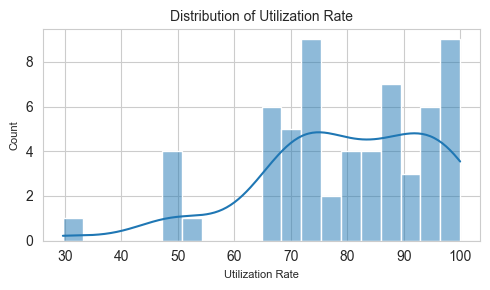

In [8]:
plt.figure(figsize=(5, 3))
sns.histplot(final_data['utilization_rate'], bins=20, kde=True)
plt.title("Distribution of Utilization Rate", fontsize=10)
plt.xlabel("Utilization Rate", fontsize=8)
plt.ylabel("Count", fontsize=8)
plt.tight_layout()
plt.show()

### Test 2: Simple Linear Regression of Numeric Predictors on Utilization Rate

**Purpose**: Find if any numeric variables predict `utilization_rate` in a univariate model.

**Testing**: 
* **Coefficient**: Change in `utilization_rate` for a one-unit increase in predictor.
* **p-value**: If predictor's effect is significantly associated with `utilization_rate` (is if \< 0.05)
* **$R^2$**: Proportion of variance in `utilization_rate` explained by the predictor alone.


In [9]:
results = []

for col in numeric_cols:
    X = final_data[[col]]
    Y = final_data['utilization_rate']
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(Y, X).fit()
    
    # Save results
    results.append({
        'Predictor': col,
        'Coefficient': model.params[col],
        'Intercept': model.params['const'],
        'R_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Convert to DataFrame for easy viewing
regression_results = pd.DataFrame(results)
print(regression_results.round(3))

             Predictor  Coefficient  Intercept  R_squared  p_value
0   Avg_Grade_Received        8.721     50.218      0.045    0.100
1     Avg_Hours_Worked        0.987     72.214      0.014    0.362
2     Learning_Average       -6.445    107.707      0.018    0.301
3    Structure_Average      -11.991    130.223      0.071    0.038
4  Environment_Average      -17.966    159.984      0.077    0.030
5    Enrolled_Resp_Pct        0.117     74.025      0.030    0.181


**Interpretation**: 
* \+ coefficient → Higher predictor values are associated with higher utilization.
* \- coefficient → Higher predictor values are associated with lower utilization.
* Significant p-value (<0.05) → Predictor reliably explains changes in utilization rate.
* $R^2$ indicates how much of the variation in utilization is captured by this single predictor.


### Test 3: Standard Multiple Linear-Regression

**Purpose**: Assess how multiple numeric variables collectively predict `utilization_rate` and identify which predictors remain significant after accounting for others. 

**Testing**: 
* **Coefficient**: Change in `utilization_rate` for a one-unit increase in predictor.
* **Standard Error**: Measures  variability of the coefficient estimate; smaller values = more precise estimates.
* **p-value**: If predictor's effect is significantly associated with `utilization_rate` (is if \< 0.05)

In [10]:
X = numeric_df.copy()  # predictors
y = final_data['utilization_rate']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Add constant for statsmodels
X_train_scaled_df = sm.add_constant(X_train_scaled_df)
X_test_scaled_df = sm.add_constant(X_test_scaled_df)

# Fit model
model = sm.OLS(y_train.values, X_train_scaled_df)  # use .values to ignore index mismatch
results = model.fit()

coef_table = results.summary2().tables[1][['Coef.', 'Std.Err.', 'P>|t|']]
coef_table = coef_table.rename(columns={
    'Coef.': 'Coefficient',
    'Std.Err.': 'Std_Error',
    'P>|t|': 'p_value'
})

coef_table.round(3)

,Coefficient,Std_Error,p_value
const,80.027,2.102,0.000
Avg_Grade_Received,2.599,2.375,0.280
Avg_Hours_Worked,1.668,2.170,0.447
Learning_Average,11.342,5.346,0.040
Structure_Average,-5.249,6.425,0.419
Environment_Average,-8.601,4.598,0.069
Enrolled_Resp_Pct,3.917,2.325,0.100


**Interpretation**: 
* We have a lot of variables with high p-values, this could be due to a multitude of reasons, such as multicolinearity, or the variables not being significantly associated with `utilization_rate` 

### Graph 3: Residual Distribution Plot
Here we plot the Residuals for the above Multivariate-Linear Model 

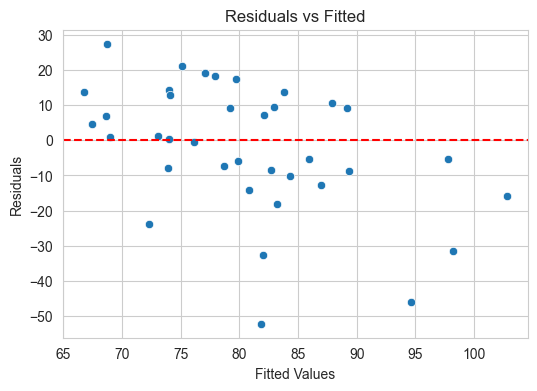

In [11]:
y_train_pred = results.predict(X_train_scaled_df)

# Compute residuals
residuals = y_train - y_train_pred

# ---- Residuals vs Fitted ----
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

### Test 4: Multiple Linear-Regression w/ Backward Elimination

**Purpose**: Backward elimination removes variables with the least statistical contribution iteratively. Since most of our variables have high p-values, then we are going to remove variables that are irrelevant to the model.

**Testing**: 
* **Mean Squared Error (MSE)**: Squared difference between predicted and actual `utilization_rate` in the test set; smaller values indicate better predictive accuracy.
* **$R^2$ (Test Set)**: Proportion of variance in `utilization_rate` explained by model on test set; ranges from 0 to 1.

In [12]:
# 1. Define predictors and target
X = numeric_df.copy() 
y = final_data['utilization_rate']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 4. Add constant for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# 5. Backward elimination function
def backward_elimination(X, y, sl=0.05, verbose=True):
    X_model = X.copy()
    while True:
        model = sm.OLS(y, X_model).fit()
        pvalues = model.pvalues.drop('const')  # ignore intercept
        max_pval = pvalues.max()
        
        if max_pval > sl:
            drop_col = pvalues.idxmax()
            if verbose:
                print(f"Dropped '{drop_col}' with p-value {max_pval:.3f}")
            X_model = X_model.drop(columns=[drop_col])
        else:
            break
    return model


# 6. Run backward elimination
X_train_scaled = X_train_scaled.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
final_model = backward_elimination(X_train_scaled, y_train)

# 7. Prepare test set with final predictors
X_test_selected = X_test_scaled[final_model.model.exog_names]

# 8. Predict on test set
y_pred = final_model.predict(X_test_selected)

# 9. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final test set MSE:", round(mse, 3))
print("Final test set R^2:", round(r2, 3))

# 10. Print value values
coef_table = pd.DataFrame({
    'Coefficient': final_model.params,
    'Std_Error': final_model.bse,
    'p_value': final_model.pvalues
}).round(3)

coef_table

Dropped 'Avg_Hours_Worked' with p-value 0.447
Dropped 'Structure_Average' with p-value 0.448
Dropped 'Avg_Grade_Received' with p-value 0.412
Dropped 'Enrolled_Resp_Pct' with p-value 0.051
Dropped 'Learning_Average' with p-value 0.065
Final test set MSE: 210.357
Final test set R^2: -0.043


,Coefficient,Std_Error,p_value
const,80.027,2.202,0.00
Environment_Average,-4.920,2.202,0.03


**Interpretation**: 
* Test Set MSE = 210.357 → The model’s predictions deviate from actual values by an average squared error of ~210.
* Test Set R² = -0.043 → The model does not explain variability in `utilization_rate` on the test set; in fact, it performs worse than predicting the mean.
* Our model has poor predictive power, suggesting that numeric course metrics alone do not reliably predict utilization rate.


---

## Advanced Analysis: Difficulty Prediction and Statistical Testing

In [13]:
# Load SET data (ONLY data source - no WebReg)
dsc_sets = pd.read_csv('datasets/dsc_sets.csv')

## Step 2: Data Cleaning and Feature Engineering

We need to:
1. Extract course numbers from course titles
2. Standardize term formats
3. Clean and extract numeric values from grade fields
4. Aggregate SET data by course and quarter
5. Create derived features for analysis

**Note:** This analysis uses ONLY SET data. No WebReg data is used.

In [14]:
# Helper function to extract course number from course title
def extract_course_number(course_title):
    """Extract numeric course number from course title (e.g., 'dsc100' -> 100)"""
    if pd.isna(course_title):
        return None
    import re
    match = re.search(r'dsc(\d+)', str(course_title).lower())
    if match:
        return int(match.group(1))
    return None

# Helper function to standardize term format
def standardize_term(term):
    """Convert term format to match webreg format (e.g., 'FA24' -> 'fa24')"""
    if pd.isna(term):
        return None
    term_str = str(term).upper()
    term_map = {
        'FA24': 'fa24', 'WI25': 'wi25', 'SP25': 'sp25',
        'FALL 2024': 'fa24', 'WINTER 2025': 'wi25', 'SPRING 2025': 'sp25',
        'FA 2024': 'fa24', 'WI 2025': 'wi25', 'SP 2025': 'sp25'
    }
    if term_str in term_map:
        return term_map[term_str]
    import re
    match = re.search(r'(FA|WI|SP|FALL|WINTER|SPRING)\s*(\d{2,4})', term_str)
    if match:
        season = match.group(1)[:2].upper()
        year = match.group(2)[-2:]
        if season.startswith('FA'):
            return f'fa{year}'
        elif season.startswith('WI'):
            return f'wi{year}'
        elif season.startswith('SP'):
            return f'sp{year}'
    return None

# Clean SET data (ONLY data source)

# First, clean column names (before creating new columns)
dsc_sets.columns = dsc_sets.columns.str.replace('*', '', regex=False)
dsc_sets.columns = dsc_sets.columns.str.replace(' ', '_')
dsc_sets.columns = dsc_sets.columns.str.replace('/', '_')

# Handle Enrolled Resp Rate columns (merge duplicates)
if "Enrolled_Resp_Rate" in dsc_sets.columns and "Enrolled__Resp_Rate" in dsc_sets.columns:
    dsc_sets["Enrolled_Resp_Rate"] = dsc_sets["Enrolled_Resp_Rate"].fillna(dsc_sets["Enrolled__Resp_Rate"])
    dsc_sets = dsc_sets.drop(columns=["Enrolled__Resp_Rate"], errors='ignore')
elif "Enrolled_Resp_Rate" in dsc_sets.columns:
    pass  # Already exists
elif "Enrolled__Resp_Rate" in dsc_sets.columns:
    dsc_sets["Enrolled_Resp_Rate"] = dsc_sets["Enrolled__Resp_Rate"]
    dsc_sets = dsc_sets.drop(columns=["Enrolled__Resp_Rate"], errors='ignore')

# Drop unnecessary columns first
dsc_sets = dsc_sets.drop(columns=["Course"], errors='ignore')

# Handle duplicate columns BEFORE converting to numeric
# Find all duplicate column names
all_cols = list(dsc_sets.columns)
duplicate_cols = [col for col in set(all_cols) if all_cols.count(col) > 1]

# For each duplicate column, merge them intelligently (keep non-NaN values)
for col_name in duplicate_cols:
    col_indices = [i for i, c in enumerate(dsc_sets.columns) if c == col_name]
    if len(col_indices) > 1:
        # Get all columns with this name
        cols_data = [dsc_sets.iloc[:, idx] for idx in col_indices]
        
        # Merge: start with first column, fill NaN with values from other columns
        merged_col = cols_data[0].copy()
        for other_col in cols_data[1:]:
            # Fill NaN values with non-NaN values from other column
            mask = merged_col.isna() & other_col.notna()
            merged_col[mask] = other_col[mask]
        
        # Replace first occurrence with merged data
        dsc_sets.iloc[:, col_indices[0]] = merged_col
        
        # Drop all other occurrences
        cols_to_drop = [dsc_sets.columns[i] for i in col_indices[1:]]
        dsc_sets = dsc_sets.drop(columns=cols_to_drop, errors='ignore')
        
        # Rename to ensure consistency (in case pandas kept different names)
        dsc_sets = dsc_sets.rename(columns={dsc_sets.columns[col_indices[0]]: col_name})

# Now remove any remaining duplicates by position
dsc_sets = dsc_sets.loc[:, ~dsc_sets.columns.duplicated(keep='first')]

# Verify duplicates are removed
remaining_duplicates = [col for col in set(dsc_sets.columns) if list(dsc_sets.columns).count(col) > 1]
if remaining_duplicates:
    # Force remove by recreating dataframe with unique columns
    dsc_sets = dsc_sets.iloc[:, ~dsc_sets.columns.duplicated(keep='first')]

# NOW extract numeric grade from Avg_Grade_Received (after duplicates are removed)
if "Avg_Grade_Received" in dsc_sets.columns:
    # Get the column as a Series (should be unique now)
    col_idx = list(dsc_sets.columns).index("Avg_Grade_Received")
    col_series = dsc_sets.iloc[:, col_idx]
    
    # Check if column contains strings (like "3.93 (A-)") or is already numeric
    if col_series.dtype == 'object':
        # Extract numeric GPA value from strings like "3.93 (A-)" or "3.93"
        # Pattern matches: start of string, digits, optional decimal point and more digits
        extracted = col_series.astype(str).str.extract(r'^(\d+\.?\d*)', expand=False)
        dsc_sets.iloc[:, col_idx] = pd.to_numeric(extracted, errors='coerce')
        non_null_count = dsc_sets.iloc[:, col_idx].notna().sum()
    else:
        # Already numeric, just ensure it's the right type
        dsc_sets.iloc[:, col_idx] = pd.to_numeric(col_series, errors='coerce')
else:
    # Try alternative names
    for col in dsc_sets.columns:
        if 'Grade' in col and 'Received' in col:
            col_idx = list(dsc_sets.columns).index(col)
            col_series = dsc_sets.iloc[:, col_idx]
            if col_series.dtype == 'object':
                # Extract numeric values from strings like "3.93 (A-)"
                extracted = col_series.astype(str).str.extract(r'^(\d+\.?\d*)', expand=False)
                dsc_sets.iloc[:, col_idx] = pd.to_numeric(extracted, errors='coerce')
            else:
                dsc_sets.iloc[:, col_idx] = pd.to_numeric(col_series, errors='coerce')
            # Rename to Avg_Grade_Received
            dsc_sets = dsc_sets.rename(columns={col: "Avg_Grade_Received"})
            break

# Extract course number and quarter
dsc_sets['course_number'] = dsc_sets['course_title'].apply(extract_course_number)
dsc_sets = dsc_sets[dsc_sets['course_number'].notna()]
dsc_sets['quarter'] = dsc_sets['Term'].apply(standardize_term)


# Safe function to get non-null count
def safe_nonnull_count(df, col_name):
    """Safely count non-null values in a column"""
    if col_name not in df.columns:
        return None
    try:
        col_idx = list(df.columns).index(col_name)
        col_data = df.iloc[:, col_idx]
        count = col_data.notna().sum()
        return int(count) if not isinstance(count, pd.Series) else int(count.iloc[0]) if len(count) > 0 else 0
    except:
        return None

hours_count = safe_nonnull_count(dsc_sets, 'Avg_Hours_Worked')
grade_count = safe_nonnull_count(dsc_sets, 'Avg_Grade_Received')
learning_count = safe_nonnull_count(dsc_sets, 'Learning_Average')
structure_count = safe_nonnull_count(dsc_sets, 'Structure_Average')
environment_count = safe_nonnull_count(dsc_sets, 'Environment_Average')



## Step 3: Aggregate SET Data and Create Feature Set

We'll aggregate SET data by course and quarter to create our feature set. The dataset will include:
- **SET features**: Learning Average, Structure Average, Environment Average, Study Hours, Grades (ALL features from SET data only)


In [15]:
# Step 3: Aggregate SET data by course and quarter

# Find the actual column names after cleaning
hours_col_set = None
grade_col_set = 'Avg_Grade_Received'  # We created this
learning_col_set = None
structure_col_set = None
environment_col_set = None

for col in dsc_sets.columns:
    if 'Hours' in col or 'hours' in col.lower():
        hours_col_set = col
    if 'Learning' in col and 'Average' in col:
        learning_col_set = col
    if 'Structure' in col and 'Average' in col:
        structure_col_set = col
    if 'Environment' in col and 'Average' in col:
        environment_col_set = col


# Convert columns to numeric before aggregation (handle any string values)
numeric_cols = []
cols_to_convert = []

if hours_col_set and hours_col_set in dsc_sets.columns:
    cols_to_convert.append(hours_col_set)
if grade_col_set and grade_col_set in dsc_sets.columns:
    cols_to_convert.append(grade_col_set)
if learning_col_set and learning_col_set in dsc_sets.columns:
    cols_to_convert.append(learning_col_set)
if structure_col_set and structure_col_set in dsc_sets.columns:
    cols_to_convert.append(structure_col_set)
if environment_col_set and environment_col_set in dsc_sets.columns:
    cols_to_convert.append(environment_col_set)

# Convert each column to numeric - handle duplicates and ensure Series
for col in cols_to_convert:
    if col in dsc_sets.columns:
        try:
            # Check if column exists and get column index
            col_indices = [i for i, c in enumerate(dsc_sets.columns) if c == col]
            if len(col_indices) > 0:
                # Use iloc to get the first occurrence as a Series
                col_idx = col_indices[0]
                col_series = dsc_sets.iloc[:, col_idx]
                
                # Special handling for grade column (may contain strings like "3.93 (A-)")
                if col == grade_col_set and col_series.dtype == 'object':
                    # Extract numeric GPA from strings like "3.93 (A-)" or "3.93"
                    # Try to extract the first numeric value (GPA)
                    extracted = col_series.astype(str).str.extract(r'^(\d+\.?\d*)', expand=False)
                    dsc_sets.iloc[:, col_idx] = pd.to_numeric(extracted, errors='coerce')
                    non_null_after = dsc_sets.iloc[:, col_idx].notna().sum()
                else:
                    # Convert to numeric (handles already-numeric or other string formats)
                    dsc_sets.iloc[:, col_idx] = pd.to_numeric(col_series, errors='coerce')
                
                numeric_cols.append(col)
        except Exception as e:
            continue


# Build aggregation dictionary (only for numeric columns with actual data)
agg_dict_set = {}
cols_to_check = [
    (hours_col_set, 'study_hours'),
    (grade_col_set, 'avg_grade'),
    (learning_col_set, 'learning_avg'),
    (structure_col_set, 'structure_avg'),
    (environment_col_set, 'environment_avg')
]

for col_name, target_name in cols_to_check:
    if col_name and col_name in numeric_cols:
        # Check if column has any non-null values
        col_idx = list(dsc_sets.columns).index(col_name) if col_name in dsc_sets.columns else None
        if col_idx is not None:
            col_data = dsc_sets.iloc[:, col_idx]
            non_null_count = col_data.notna().sum()
            if non_null_count > 0:
                agg_dict_set[col_name] = 'mean'

if len(agg_dict_set) > 0:
    # Only aggregate numeric columns
    merged_df = dsc_sets.groupby(['course_number', 'quarter'])[list(agg_dict_set.keys())].mean().reset_index()
    
    # Rename columns
    rename_dict_set = {}
    if hours_col_set and hours_col_set in merged_df.columns:
        rename_dict_set[hours_col_set] = 'study_hours'
    if grade_col_set and grade_col_set in merged_df.columns:
        rename_dict_set[grade_col_set] = 'avg_grade'
    if learning_col_set and learning_col_set in merged_df.columns:
        rename_dict_set[learning_col_set] = 'learning_avg'
    if structure_col_set and structure_col_set in merged_df.columns:
        rename_dict_set[structure_col_set] = 'structure_avg'
    if environment_col_set and environment_col_set in merged_df.columns:
        rename_dict_set[environment_col_set] = 'environment_avg'
    
    merged_df = merged_df.rename(columns=rename_dict_set)
else:
    merged_df = pd.DataFrame(columns=['course_number', 'quarter', 'study_hours', 'avg_grade',
                                     'learning_avg', 'structure_avg', 'environment_avg'])


# Check data completeness with safe column access

def safe_count(df, col_name):
    """Safely count non-null values in a column, handling duplicates"""
    if col_name not in df.columns:
        return None
    try:
        # Get column by index to avoid duplicate issues
        col_indices = [i for i, c in enumerate(df.columns) if c == col_name]
        if len(col_indices) > 0:
            col_idx = col_indices[0]
            col_data = df.iloc[:, col_idx]
            count = col_data.notna().sum()
            # Ensure it's a scalar
            if isinstance(count, pd.Series):
                count = count.iloc[0] if len(count) > 0 else 0
            return int(count)
    except Exception as e:
        return None
    return None

study_hours_count = safe_count(merged_df, 'study_hours')
avg_grade_count = safe_count(merged_df, 'avg_grade')
learning_count = safe_count(merged_df, 'learning_avg')
structure_count = safe_count(merged_df, 'structure_avg')
environment_count = safe_count(merged_df, 'environment_avg')

merged_df.head()


,course_number,quarter,study_hours,avg_grade,learning_avg,structure_avg,environment_avg
0,10,fa23,8.475000,3.26,4.407500,4.030000,4.492500
1,10,fa24,7.422000,3.014,4.520000,4.332000,4.592000
2,10,sp24,7.980000,2.9,4.436667,4.190000,4.526667
3,10,sp25,7.115000,2.995,4.460000,4.260000,4.485000
4,10,wi24,8.116667,2.943333,4.390000,4.043333,4.483333


## Step 4: Manually Define Difficulty Labels (Ground Truth)

**Key Decision: Choosing the Feature for Manual Difficulty Definition**

We will use **Study Hours** (Avg_Hours_Worked) from SET data as our manual difficulty definition because:

1. **Direct Workload Indicator**: Study hours directly reflect the time commitment required, which correlates with difficulty
2. **Objective Measure**: Based on actual reported hours, not subjective ratings
3. **Interpretable**: Higher hours = more difficult/time-consuming course
4. **Available in SET Data**: We have complete SET data with study hours for all courses

**Definition:**
- **Difficult (1)**: Study hours ≥ median (courses requiring more time commitment)
- **Easy (0)**: Study hours < median (courses requiring less time commitment)

This creates a balanced binary classification problem based on workload/difficulty.

**Note:** All features (study hours, learning, structure, environment averages, grades) come from SET data only.


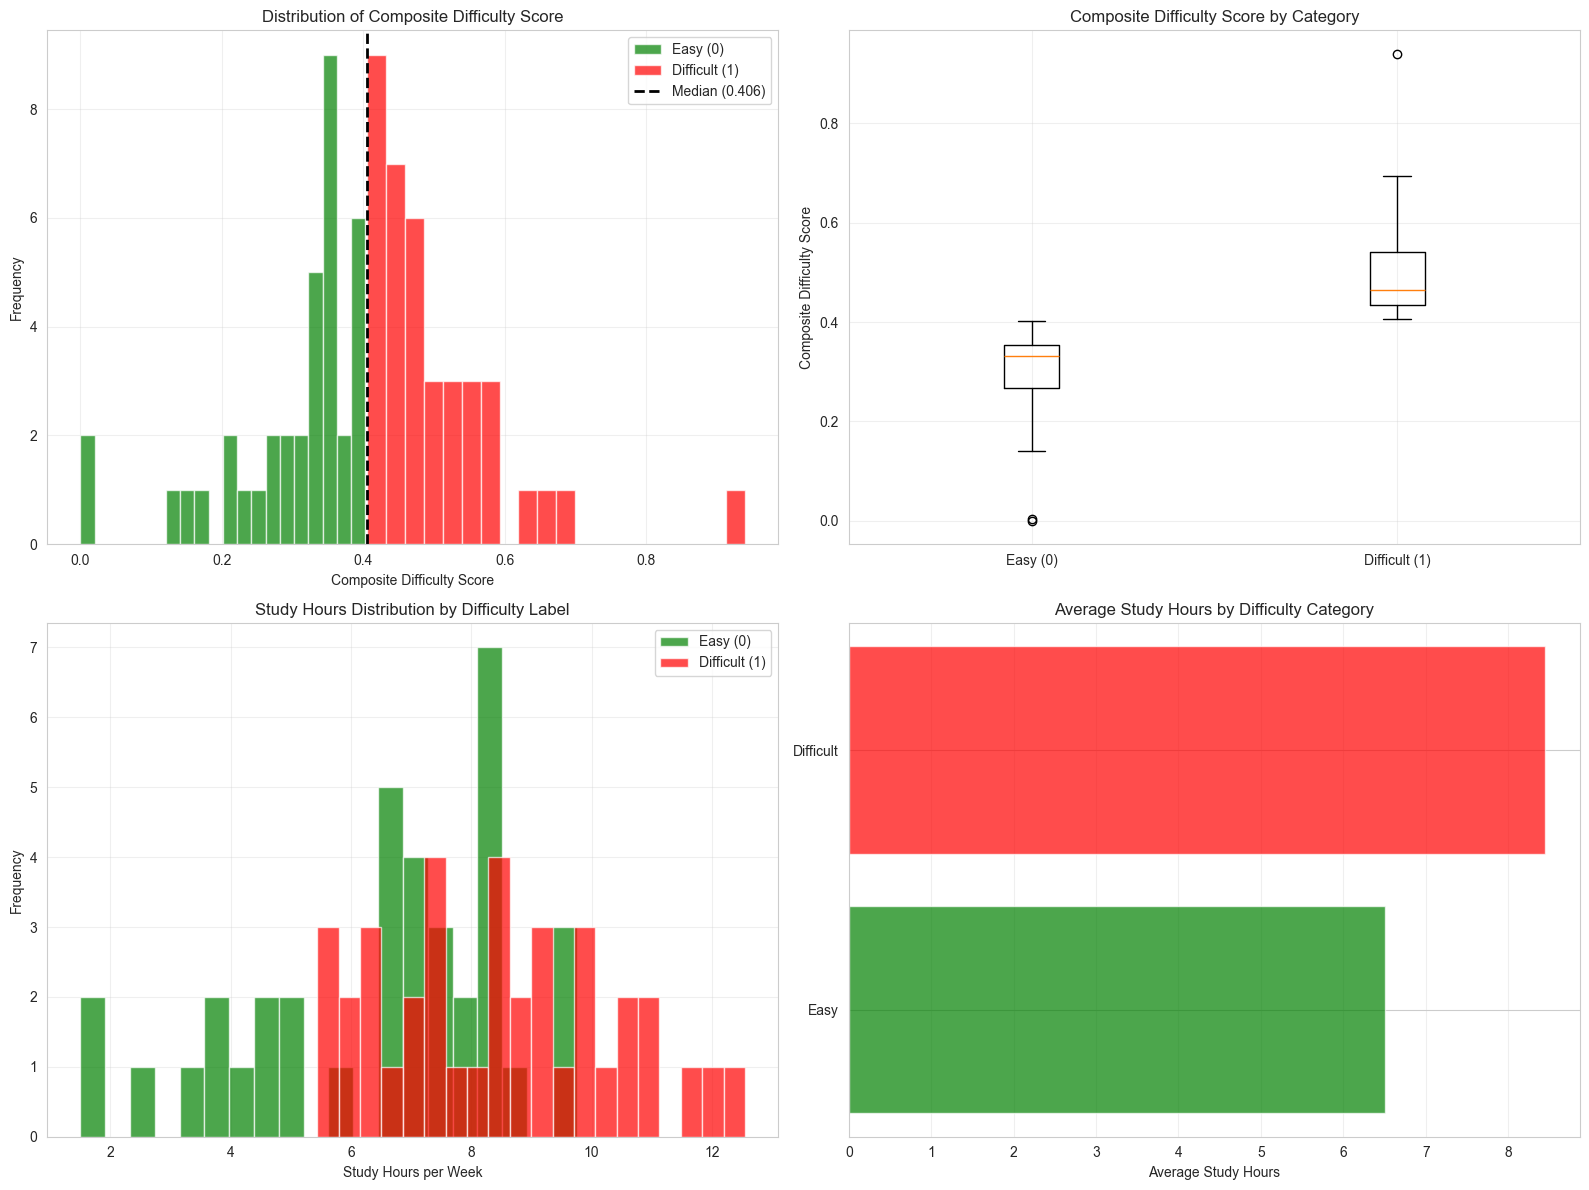

In [16]:
# Step 4: Manually define difficulty based on multiple SET features

# Filter to rows with all required features
required_features = ['study_hours', 'learning_avg', 'structure_avg', 'environment_avg']
df_with_features = merged_df[merged_df[required_features].notna().all(axis=1)].copy()

if len(df_with_features) == 0:
    # Use courses with at least study_hours
    df_with_features = merged_df[merged_df['study_hours'].notna()].copy()

# Create composite difficulty score
# Normalize each feature to [0, 1] range, then combine

# Initialize difficulty components
difficulty_components = {}

# 1. Study hours: Higher = more difficult (normalize to [0,1])
if 'study_hours' in df_with_features.columns and df_with_features['study_hours'].notna().sum() > 0:
    hours_min = df_with_features['study_hours'].min()
    hours_max = df_with_features['study_hours'].max()
    if hours_max > hours_min:
        difficulty_components['study_hours'] = (df_with_features['study_hours'] - hours_min) / (hours_max - hours_min)
    else:
        difficulty_components['study_hours'] = pd.Series(0.5, index=df_with_features.index)

# 2. Learning average: Lower = more difficult (invert and normalize)
if 'learning_avg' in df_with_features.columns and df_with_features['learning_avg'].notna().sum() > 0:
    learning_min = df_with_features['learning_avg'].min()
    learning_max = df_with_features['learning_avg'].max()
    if learning_max > learning_min:
        # Invert: lower learning_avg -> higher difficulty score
        difficulty_components['learning_avg'] = 1 - ((df_with_features['learning_avg'] - learning_min) / (learning_max - learning_min))
    else:
        difficulty_components['learning_avg'] = pd.Series(0.5, index=df_with_features.index)

# 3. Structure average: Lower = more difficult (invert and normalize)
if 'structure_avg' in df_with_features.columns and df_with_features['structure_avg'].notna().sum() > 0:
    structure_min = df_with_features['structure_avg'].min()
    structure_max = df_with_features['structure_avg'].max()
    if structure_max > structure_min:
        # Invert: lower structure_avg -> higher difficulty score
        difficulty_components['structure_avg'] = 1 - ((df_with_features['structure_avg'] - structure_min) / (structure_max - structure_min))
    else:
        difficulty_components['structure_avg'] = pd.Series(0.5, index=df_with_features.index)

# 4. Environment average: Lower = more difficult (invert and normalize)
if 'environment_avg' in df_with_features.columns and df_with_features['environment_avg'].notna().sum() > 0:
    env_min = df_with_features['environment_avg'].min()
    env_max = df_with_features['environment_avg'].max()
    if env_max > env_min:
        # Invert: lower environment_avg -> higher difficulty score
        difficulty_components['environment_avg'] = 1 - ((df_with_features['environment_avg'] - env_min) / (env_max - env_min))
    else:
        difficulty_components['environment_avg'] = pd.Series(0.5, index=df_with_features.index)

# Combine all components into composite difficulty score (equal weights)
if len(difficulty_components) > 0:
    # Average all available components
    composite_scores = pd.DataFrame(difficulty_components).mean(axis=1)
    df_with_features['difficulty_score'] = composite_scores
    
    
    # Calculate median of composite score
    median_score = composite_scores.median()
    
    # Define difficulty labels based on median split of composite score
    # Difficult = 1 (composite score >= median)
    # Easy = 0 (composite score < median)
    df_with_features['difficulty_manual'] = (df_with_features['difficulty_score'] >= median_score).astype(int)
    
    # Create individual difficulty labels for each feature based on median split
    
    # 1. Study hours: Higher = more difficult
    if 'study_hours' in df_with_features.columns and df_with_features['study_hours'].notna().sum() > 0:
        median_hours = df_with_features['study_hours'].median()
        df_with_features['difficulty_study_hours'] = (df_with_features['study_hours'] >= median_hours).astype(int)
    
    # 2. Average grade: Lower = more difficult (invert)
    if 'avg_grade' in df_with_features.columns and df_with_features['avg_grade'].notna().sum() > 0:
        median_grade = df_with_features['avg_grade'].median()
        df_with_features['difficulty_avg_grade'] = (df_with_features['avg_grade'] < median_grade).astype(int)
    
    # 3. Learning average: Lower = more difficult (invert)
    if 'learning_avg' in df_with_features.columns and df_with_features['learning_avg'].notna().sum() > 0:
        median_learning = df_with_features['learning_avg'].median()
        df_with_features['difficulty_learning_avg'] = (df_with_features['learning_avg'] < median_learning).astype(int)
    
    # 4. Structure average: Lower = more difficult (invert)
    if 'structure_avg' in df_with_features.columns and df_with_features['structure_avg'].notna().sum() > 0:
        median_structure = df_with_features['structure_avg'].median()
        df_with_features['difficulty_structure_avg'] = (df_with_features['structure_avg'] < median_structure).astype(int)
    
    # 5. Environment average: Lower = more difficult (invert)
    if 'environment_avg' in df_with_features.columns and df_with_features['environment_avg'].notna().sum() > 0:
        median_environment = df_with_features['environment_avg'].median()
        df_with_features['difficulty_environment_avg'] = (df_with_features['environment_avg'] < median_environment).astype(int)
    
else:
    df_with_features['difficulty_score'] = 0.5
    df_with_features['difficulty_manual'] = 0


# Show statistics by difficulty category

# Build aggregation dictionary with available features
agg_dict = {
    'difficulty_score': ['mean', 'std', 'min', 'max'],
    'course_number': ['mean', 'std', 'min', 'max']
}

# Add features if they exist
if 'study_hours' in df_with_features.columns:
    agg_dict['study_hours'] = ['mean', 'std', 'min', 'max']
if 'avg_grade' in df_with_features.columns:
    agg_dict['avg_grade'] = ['mean', 'std']
if 'learning_avg' in df_with_features.columns:
    agg_dict['learning_avg'] = ['mean', 'std']
if 'structure_avg' in df_with_features.columns:
    agg_dict['structure_avg'] = ['mean', 'std']
if 'environment_avg' in df_with_features.columns:
    agg_dict['environment_avg'] = ['mean', 'std']

difficulty_stats = df_with_features.groupby('difficulty_manual').agg(agg_dict).round(4)

# Visualize the distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of composite difficulty score by difficulty label
if 'difficulty_score' in df_with_features.columns:
    axes[0, 0].hist(df_with_features[df_with_features['difficulty_manual']==0]['difficulty_score'], 
                    bins=20, alpha=0.7, label='Easy (0)', color='green')
    axes[0, 0].hist(df_with_features[df_with_features['difficulty_manual']==1]['difficulty_score'], 
                    bins=20, alpha=0.7, label='Difficult (1)', color='red')
    if 'difficulty_score' in df_with_features.columns:
        median_score = df_with_features['difficulty_score'].median()
        axes[0, 0].axvline(median_score, color='black', linestyle='--', linewidth=2, 
                          label=f'Median ({median_score:.3f})')
    axes[0, 0].set_xlabel('Composite Difficulty Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Composite Difficulty Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot comparing composite difficulty score
if 'difficulty_score' in df_with_features.columns:
    box_data = [
        df_with_features[df_with_features['difficulty_manual']==0]['difficulty_score'].values,
        df_with_features[df_with_features['difficulty_manual']==1]['difficulty_score'].values
    ]
    axes[0, 1].boxplot(box_data, labels=['Easy (0)', 'Difficult (1)'])
    axes[0, 1].set_ylabel('Composite Difficulty Score')
    axes[0, 1].set_title('Composite Difficulty Score by Category')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Study hours by difficulty (if available)
if 'study_hours' in df_with_features.columns:
    axes[1, 0].hist(df_with_features[df_with_features['difficulty_manual']==0]['study_hours'], 
                    bins=20, alpha=0.7, label='Easy (0)', color='green')
    axes[1, 0].hist(df_with_features[df_with_features['difficulty_manual']==1]['study_hours'], 
                    bins=20, alpha=0.7, label='Difficult (1)', color='red')
    axes[1, 0].set_xlabel('Study Hours per Week')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Study Hours Distribution by Difficulty Label')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 4. Component contributions visualization
if len(difficulty_components) > 0:
    component_names = list(difficulty_components.keys())
    easy_means = [df_with_features[df_with_features['difficulty_manual']==0][f'difficulty_score'].mean() 
                  if 'difficulty_score' in df_with_features.columns else 0.5]
    difficult_means = [df_with_features[df_with_features['difficulty_manual']==1][f'difficulty_score'].mean() 
                       if 'difficulty_score' in df_with_features.columns else 0.5]
    
    # Show average component values by difficulty
    if 'study_hours' in df_with_features.columns:
        easy_hours = df_with_features[df_with_features['difficulty_manual']==0]['study_hours'].mean()
        diff_hours = df_with_features[df_with_features['difficulty_manual']==1]['study_hours'].mean()
        axes[1, 1].barh(['Easy', 'Difficult'], [easy_hours, diff_hours], 
                       color=['green', 'red'], alpha=0.7)
        axes[1, 1].set_xlabel('Average Study Hours')
        axes[1, 1].set_title('Average Study Hours by Difficulty Category')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 1].text(0.5, 0.5, 'Study hours data\nnot available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Component Analysis')

plt.tight_layout()
plt.savefig('difficulty_manual_definition.png', dpi=300, bbox_inches='tight')
plt.show()


difficulty_cols = [col for col in df_with_features.columns if col.startswith('difficulty_')]
for col in sorted(difficulty_cols):
    if col not in ['difficulty_score', 'difficulty_manual']:
        non_null = df_with_features[col].notna().sum()



## Step 5: Merge Utilization Rate and Run T-Tests

We will:
1. Load utilization_rate data from WebReg
2. Merge with our difficulty-labeled dataset
3. Run independent samples t-tests comparing utilization_rate between Easy (0) and Difficult (1) for each difficulty feature


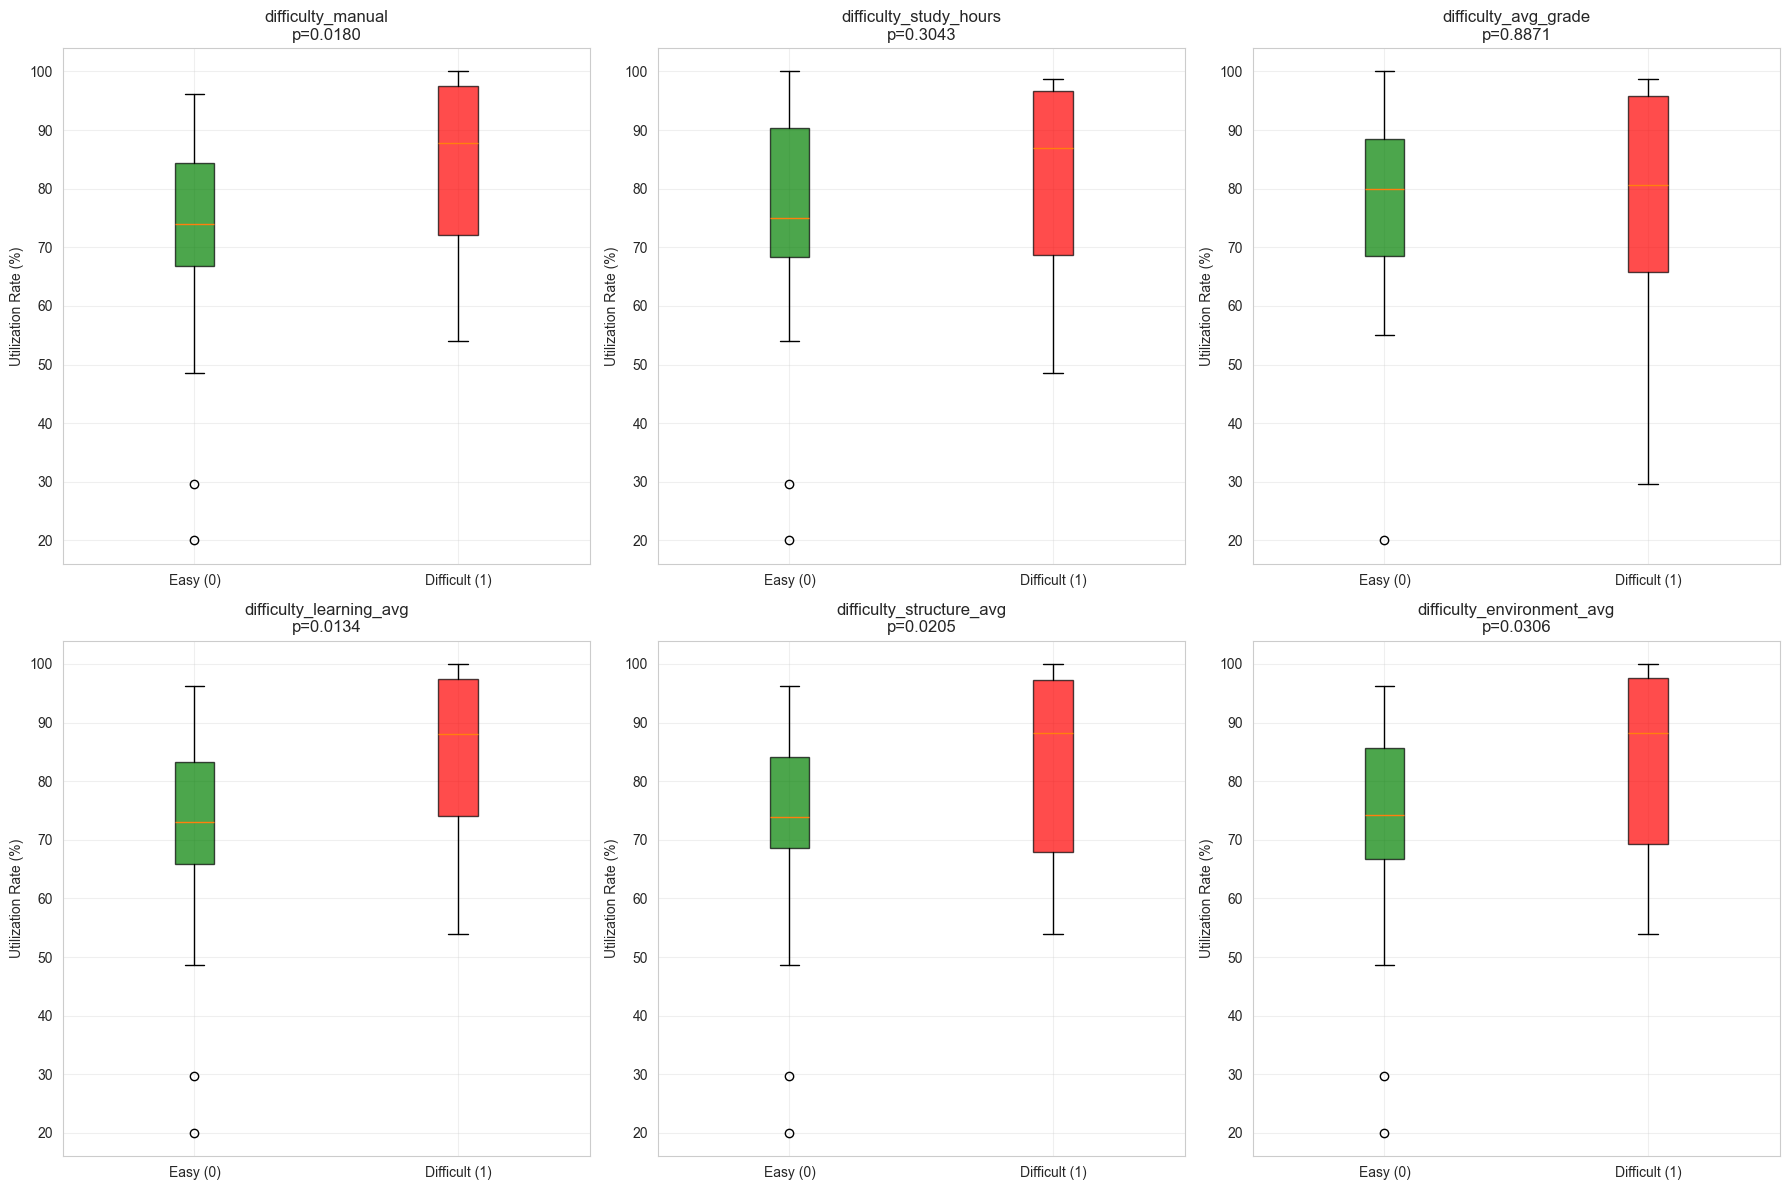

In [17]:
# Step 5: Merge utilization_rate and run t-tests

# Load WebReg data with utilization_rate
webreg_data = pd.read_csv('webreg_data/results/webreg_processed_data.csv')

# Prepare WebReg data for merging
# Extract course number from course column (format: dsc_100 -> 100)
def extract_course_num_from_webreg(course_str):
    """Extract course number from webreg course format (e.g., 'dsc_100' -> 100)"""
    if pd.isna(course_str):
        return None
    import re
    match = re.search(r'dsc[_\s]*(\d+)', str(course_str).lower())
    if match:
        return int(match.group(1))
    return None

webreg_data['course_number'] = webreg_data['course'].apply(extract_course_num_from_webreg)
webreg_data['quarter'] = webreg_data['quarter'].str.lower()

# Select only the columns we need
webreg_merge = webreg_data[['course_number', 'quarter', 'utilization_rate']].copy()

# Merge with df_with_features
df_with_util = df_with_features.merge(
    webreg_merge,
    on=['course_number', 'quarter'],
    how='inner'
)


# Get all difficulty feature columns
difficulty_features = [col for col in df_with_util.columns if col.startswith('difficulty_') and col != 'difficulty_score']

# Run independent samples t-tests for each difficulty feature

t_test_results = []

for feature in difficulty_features:
    if feature not in df_with_util.columns:
        continue
    
    # Get groups
    easy_group = df_with_util[df_with_util[feature] == 0]['utilization_rate'].dropna()
    difficult_group = df_with_util[df_with_util[feature] == 1]['utilization_rate'].dropna()
    
    if len(easy_group) == 0 or len(difficult_group) == 0:
        continue
    
    # Calculate means
    easy_mean = easy_group.mean()
    difficult_mean = difficult_group.mean()
    mean_diff = abs(difficult_mean - easy_mean)
    
    # Run t-test
    t_stat, p_value = ttest_ind(easy_group, difficult_group)
    
    # Store results
    t_test_results.append({
        'Difficulty_Feature': feature,
        'Easy_Mean': easy_mean,
        'Difficult_Mean': difficult_mean,
        'Mean_Difference': mean_diff,
        't_statistic': abs(t_stat),  # Use absolute value to match absolute mean difference
        'p_value': p_value,
        'n_Easy': len(easy_group),
        'n_Difficult': len(difficult_group),
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })
    

# Create results DataFrame
t_test_df = pd.DataFrame(t_test_results)


# Visualize results
if len(t_test_results) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, feature in enumerate(difficulty_features[:6]):  # Plot up to 6 features
        if feature not in df_with_util.columns:
            continue
        
        easy_group = df_with_util[df_with_util[feature] == 0]['utilization_rate'].dropna()
        difficult_group = df_with_util[df_with_util[feature] == 1]['utilization_rate'].dropna()
        
        if len(easy_group) == 0 or len(difficult_group) == 0:
            continue
        
        # Box plot
        box_data = [easy_group.values, difficult_group.values]
        bp = axes[idx].boxplot(box_data, labels=['Easy (0)', 'Difficult (1)'], patch_artist=True)
        bp['boxes'][0].set_facecolor('green')
        bp['boxes'][0].set_alpha(0.7)
        bp['boxes'][1].set_facecolor('red')
        bp['boxes'][1].set_alpha(0.7)
        
        axes[idx].set_ylabel('Utilization Rate (%)')
        axes[idx].set_title(f'{feature}\np={t_test_df[t_test_df["Difficulty_Feature"]==feature]["p_value"].values[0]:.4f}')
        axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(difficulty_features), 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('t_test_utilization_by_difficulty.png', dpi=300, bbox_inches='tight')
    plt.show()



## Step 6: Two-Way ANOVA Tests

We will run two-way ANOVA tests to examine interaction effects between:
- **Composite difficulty score** (`difficulty_manual`) × **Individual features** (study_hours, avg_grade, learning_avg, structure_avg, environment_avg)

**Purpose**: Test if the relationship between each feature and utilization_rate differs significantly between Easy (0) and Difficult (1) courses.

**Hypotheses**:
- **H₀**: No interaction effect (the relationship between feature and utilization_rate is the same for Easy and Difficult courses)
- **H₁**: Significant interaction effect (the relationship differs between Easy and Difficult courses)


In [18]:
# Step 6: Two-way ANOVA tests

# Features to test interactions with
interaction_features = ['study_hours', 'avg_grade', 'learning_avg', 'structure_avg', 'environment_avg']

anova_results = []

for feature in interaction_features:
    if feature not in df_with_util.columns:
        continue
    
    # Filter to rows with all required data
    test_data = df_with_util[[
        'difficulty_manual', 
        feature, 
        'utilization_rate'
    ]].dropna()
    
    if len(test_data) < 10:  # Need minimum data
        continue
    
    # Convert difficulty_manual to categorical for ANOVA
    test_data['difficulty_manual'] = test_data['difficulty_manual'].astype('category')
    
    # Create interaction term formula
    # Format: utilization_rate ~ C(difficulty_manual) * feature
    formula = f'utilization_rate ~ C(difficulty_manual) * {feature}'
    
    try:
        # Fit two-way ANOVA model
        model = ols(formula, data=test_data).fit()
        anova_table = anova_lm(model, typ=2)
        
        # Extract interaction p-value
        interaction_row = anova_table.loc[f'C(difficulty_manual):{feature}']
        interaction_p = interaction_row['PR(>F)']
        
        # Extract main effects
        main_effect_diff = anova_table.loc['C(difficulty_manual)', 'PR(>F)']
        main_effect_feature = anova_table.loc[feature, 'PR(>F)']
        
        # Calculate means for each group
        means = test_data.groupby('difficulty_manual').agg({
            feature: 'mean',
            'utilization_rate': 'mean'
        })
        
        # Store results
        anova_results.append({
            'Feature': feature,
            'Interaction_p_value': interaction_p,
            'Main_Effect_Difficulty_p': main_effect_diff,
            'Main_Effect_Feature_p': main_effect_feature,
            'Easy_Mean_Feature': means.loc[0, feature],
            'Difficult_Mean_Feature': means.loc[1, feature],
            'Easy_Mean_Utilization': means.loc[0, 'utilization_rate'],
            'Difficult_Mean_Utilization': means.loc[1, 'utilization_rate'],
            'n': len(test_data),
            'Interaction_Significant': 'Yes' if interaction_p < 0.05 else 'No'
        })
        
    except Exception as e:
        continue

# Create results DataFrame
anova_df = pd.DataFrame(anova_results)

if len(anova_df) > 0:
    anova_df